In [1]:
import sys
import os

notebook_cwd = os.getcwd()
src_path = os.path.join(notebook_cwd, '..')
if src_path not in sys.path:
    sys.path.append(src_path)


# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.interface.configuration import load_config

%matplotlib inline


In [3]:
def print_attributes(cls, title: str = "Class Attributes"):
    print(f"\n{title}")
    for attribute, path in cls.__dict__.items():
        print(f"- {attribute}: {path}")


# Loading project configuration

In [4]:
config = load_config()
directories_paths = config.directory_paths
json_paths = config.database_paths

print(f"\nProject Path: {directories_paths.project}")
print_attributes(cls=directories_paths, title="Directory Paths:")    
print_attributes(cls=json_paths, title="Database JSON File Paths:")   


Project Path: /home/jounim/Work/codebase_projects/inverspyctrometry

Directory Paths:
- data: /home/jounim/Work/codebase_projects/inverspyctrometry/data
- datasets: /home/jounim/Work/codebase_projects/inverspyctrometry/data/datasets
- notebooks: /home/jounim/Work/codebase_projects/inverspyctrometry/notebooks
- reports: /home/jounim/Work/codebase_projects/inverspyctrometry/reports
- src: /home/jounim/Work/codebase_projects/inverspyctrometry/src

Database JSON File Paths:
- characterizations: /home/jounim/Work/codebase_projects/inverspyctrometry/data/database/characterizations.json
- datasets: /home/jounim/Work/codebase_projects/inverspyctrometry/data/database/datasets.json
- interferometers: /home/jounim/Work/codebase_projects/inverspyctrometry/data/database/interferometers.json
- inversion_protocols: /home/jounim/Work/codebase_projects/inverspyctrometry/data/database/inversion_protocols.json
- noise_levels: /home/jounim/Work/codebase_projects/inverspyctrometry/data/database/noise_leve

# Opening / Loading the Database

In [5]:
database = config.database()

print("Database \"Tables\":")
for attribute in database.__dict__.keys():
    print(f"- {attribute}")
    

Database "Tables":
- characterizations
- datasets
- experiments
- interferometers
- inversion_protocols
- noise_levels


## Loading an interferometric device

An interferometric device is represented by the ```Interferometer``` class children:
* Michelson Interferometer: ```MichelsonInterferometer```
* Fabry-Perot Interferometer: ```FabryPerotInterferometer```

Each interferometric device is characterized  / parametrized by the following parameters:
* Transmittance coefficients (polynomial coefficients): ```transmittance_coefficients```
* Reflectivity coefficients (polynomial coefficients): ```reflectance_coefficients```
* Optical Path Differences (OPD): ```opds```
* Phase shifts: ```phase_shift```

It is possible to store the parameters of an interferometric device in two ways:
* By directly registering their values in the ```JSON``` file (useful for simulations and easy / free manipulations), which is ```interferometers.json```. In this case, it is also possible to freely choose the harmonic_order of a Fabry-Perot device.
* By storing the values in ```.npy``` files (useful when loading characterizations parametrized from real devices), which is ```characterizations.json``` [1].

After that, the database is used to generate an ```Interferometer``` object.

In the database, it is specified whether an interferometer record is of type Michelson or Fabry-Perot.

*[1] Picone, Daniele, et al. "Interferometer response characterization algorithm for multi-aperture Fabry-Perot imaging spectrometers." Optics Express 31.14 (2023): 23066-23085.*

### Loading from the interferometers option

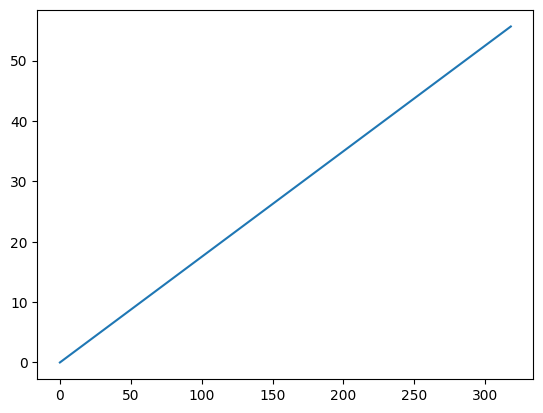

In [6]:
interferometer_id = 4

interferometer = database.interferometer(interferometer_id=interferometer_id)

plt.plot(interferometer.opds)

### Loading from the characterizations option

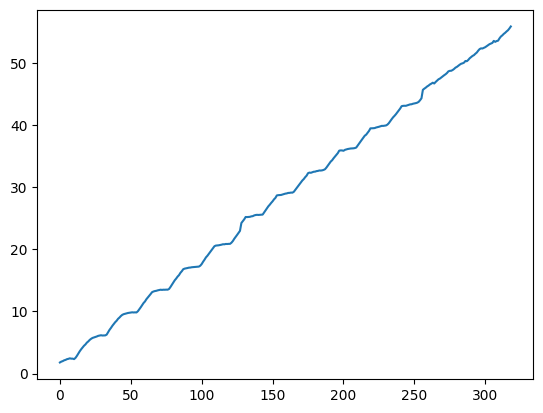

In [7]:
characterization_id = 0

characterization = database.characterization(characterization_id=characterization_id)
interferometer = characterization.interferometer()

plt.plot(interferometer.opds)

## Loading a dataset

A dataset can be loaded using the dataset id.

There are two categories of datasets:
* Spectrum datasets
* Interferogram datasets

Spectrum datasets are represented by the ```Spectrum``` class, containing the following attributes:
* Data: ```data```
* Corresponding wavenumbers: ```wavenumbers```
* Wavenumbers unit: ```wavenumbers_unit```

Interferogram datasets are represented by the ```Interferogram``` class, containing the following attributes:
* Data: ```data```
* Corresponding Optical Path Differences (OPDs): ```opds```
* OPDs unit: ```opds_unit```

The following code snippet is used to load a dataset from the database.
The method returns a ```Spectrum``` or an ```Interferogram``` based on the category of the dataset record in the database.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Dataset shape: (204, 24)


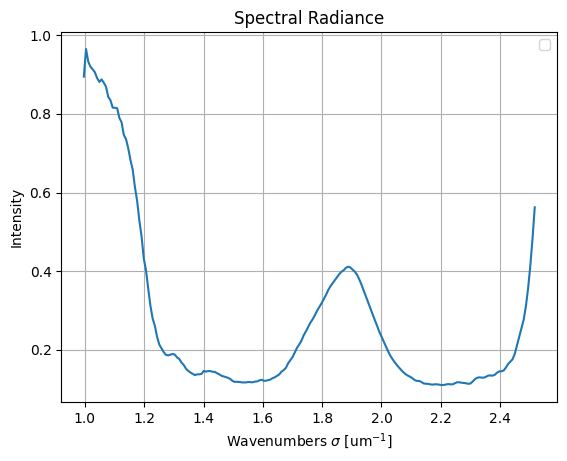

In [8]:
dataset_id = 1

dataset = database.dataset(dataset_id=dataset_id)

print(f"\nDataset shape: {dataset.data.shape}")

fig, axs = plt.subplots(1, 1, squeeze=False)
dataset.visualize(axs=axs[0, 0], acq_ind=13)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Dataset shape: (319, 451)


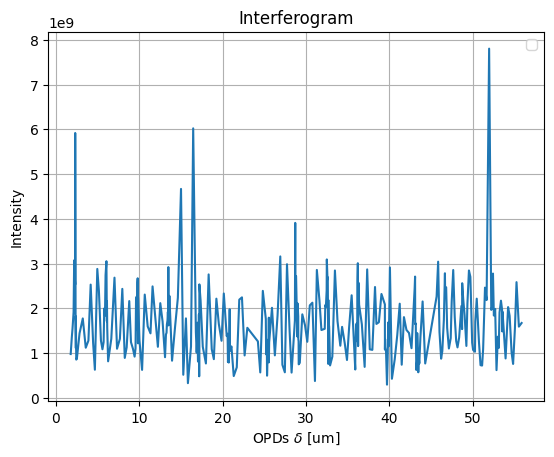

In [9]:
dataset_id = 3

dataset = database.dataset(dataset_id=dataset_id)

print(f"\nDataset shape: {dataset.data.shape}")

fig, axs = plt.subplots(1, 1, squeeze=False)
dataset.visualize(axs=axs[0, 0], acq_ind=13)

It is also possible to load the central wavenumbers directly:
* For spectrum datasets, this simply represents the corresponding wavenumbers samples.
* For interferogram datasets, if exists, this refers to the wavenumbers used in the instrument line shape of the device [1].

*[1] Picone, Daniele, et al. "Interferometer response characterization algorithm for multi-aperture Fabry-Perot imaging spectrometers." Optics Express 31.14 (2023): 23066-23085.*

In [10]:
dataset_id = 1

wavenumbers = database.dataset_central_wavenumbers(dataset_id=dataset_id)

print(f"Central wavenumbers length: {wavenumbers.size}")

Central wavenumbers length: 204


## Loading an inversion protocol

The inversion protocol is represented by the ```InversionProtocol``` class.
The supported inversion protocol types are:
* The Inverse Discrete Cosine Transform (IDCT): ```IDCT```
* The Moore-Penrose inverse (pseudo-inverse): ```PseudoInverse```
* The Truncated Singular Value Decomposition (TSVD): ```TSVD```
* The Tikhonov regularization / Ridge Regression (RR): ```RidgeRegression```
* The Loris-Verhoeven (LV) algorithm: ```LorisVerhoeven```

In the database, a range of regularization parameters is provided for each inversion protocol record (the number of parameters can also be one). Thus, generally speaking, when loading the inversion protocol from the database, a list of the ```InversionProtocol``` class objects is provided, of the same inversion protocol type, each with a different regularization parameter.

In [11]:
inv_protocol_id = 2

inv_protocols = database.inversion_protocol_list(inv_protocol_id=inv_protocol_id)

print(f"Number of inversion protocols: {len(inv_protocols)}")
print(f"Type of inversion protocol: {type(inv_protocols[0])}")

Number of inversion protocols: 100
Type of inversion protocol: <class 'src.inverse_model.protocols.TSVD'>


It is also possible to:
* Load an inversion protocol with a specific regularization parameter.
* Load only the array of regularization parameters.

In [21]:
inv_protocol_id = 2

reg_param = 0.6
inv_protocol = database.inversion_protocol(inv_protocol_id=inv_protocol_id, lambdaa=reg_param)
print(f"\nInversion Protocol with a chosen regularization parameter:")
print(f"- Type: {type(inv_protocol)}")
print(f"- Info: {inv_protocol}")

reg_params_array = database.inversion_protocol_lambdaas(inv_protocol_id=inv_protocol_id)
print(f"\nRange of regularization parameters:\n{np.round(reg_params_array, decimals=3)}")


Inversion Protocol with a chosen regularization parameter:
- Type: <class 'src.inverse_model.protocols.TSVD'>
- Info: TSVD(penalization_ratio=0.6)

Range of regularization parameters:
[0.4   0.406 0.412 0.418 0.424 0.43  0.436 0.442 0.448 0.455 0.461 0.467
 0.473 0.479 0.485 0.491 0.497 0.503 0.509 0.515 0.521 0.527 0.533 0.539
 0.545 0.552 0.558 0.564 0.57  0.576 0.582 0.588 0.594 0.6   0.606 0.612
 0.618 0.624 0.63  0.636 0.642 0.648 0.655 0.661 0.667 0.673 0.679 0.685
 0.691 0.697 0.703 0.709 0.715 0.721 0.727 0.733 0.739 0.745 0.752 0.758
 0.764 0.77  0.776 0.782 0.788 0.794 0.8   0.806 0.812 0.818 0.824 0.83
 0.836 0.842 0.848 0.855 0.861 0.867 0.873 0.879 0.885 0.891 0.897 0.903
 0.909 0.915 0.921 0.927 0.933 0.939 0.945 0.952 0.958 0.964 0.97  0.976
 0.982 0.988 0.994 1.   ]
